In [195]:
import pyodbc
import pandas as pd

cnxn = pyodbc.connect('Trusted_Connection=yes', driver='{SQL Server}', server='data-dw04', database='CCMS')
cursor = cnxn.cursor()

query1 = """
SELECT 
    ah.Lead__c,
    CAST(d.media_week AS date) AS media_week,
    CAST(ah.createddate AS date) AS sched_date,
    ci.id AS consult_inventory,
    CAST(ci.Apt_Date__c AS date) AS Apt_Date__c,
    CASE 
        WHEN ah.external_agent__c = 'online schedule' THEN 'web' 
        WHEN ah.external_agent__c IS NOT NULL THEN 'imc' 
        ELSE 'ccms' 
    END AS sched_source,
    datediff(day, ah.createddate, ci.apt_date__c) AS sched_age,
    CAST(dd.media_week AS date) AS apt_week,
    ctr.[name] AS center
FROM 
    CCMS.Salesforce.VW_AptHistory ah
    LEFT JOIN CCMS.dbo.VW_Date_Dim d ON d.actualdate = CAST(ah.createddate AS date)
    LEFT JOIN CCMS.Salesforce.VW_ConsultInventory ci ON ci.id = ah.Consult_Inventory__c
    LEFT JOIN CCMS.Salesforce.VW_ConsultRooms cr ON cr.id = ci.Consult_Room__c
    LEFT JOIN CCMS.Salesforce.VW_Center ctr ON ctr.id = cr.center_information__c
    LEFT JOIN CCMS.dbo.VW_Date_Dim dd ON dd.actualdate = CAST(ci.apt_date__C AS date)
WHERE 
    ah.Action__c = 'scheduled'
    AND ah.Notes__c = 'consultation has been scheduled'
    AND ah.createddate >= (getdate() - 78)
    AND cr.room_type__c <> 'practice'
"""

query2 = """
SELECT 
    bli.center,
    SUM(bli.baseline_inventory) AS 'inventory',
    bli.week, 
    CASE 
        WHEN c.Max_Propensity_for_Slots__c > .8 AND c.Max_Blocks_per_PEC__c > 2 THEN 'Open' 
        WHEN c.Max_Propensity_for_Slots__c < .8 THEN 'Closed' 
        ELSE 'Medium' 
    END AS 'FIS_Status'
FROM 
    CCMS.Analytics.VW_baseline_inventory bli
    LEFT JOIN CCMS.Salesforce.VW_Center c ON c.Name = bli.center
WHERE 
    bli.week BETWEEN (getdate() - 48) AND (getdate() + 48)
GROUP BY 
    bli.center, 
    bli.week, 
    CASE 
        WHEN c.Max_Propensity_for_Slots__c > .8 AND c.Max_Blocks_per_PEC__c > 2 THEN 'Open' 
        WHEN c.Max_Propensity_for_Slots__c < .8 THEN 'Closed' 
        ELSE 'Medium' 
    END
"""

scheds = pd.read_sql(query1, cnxn)
bli = pd.read_sql(query2, cnxn)
cnxn.close()

bli['week'] = pd.to_datetime(bli['week'])
date_cols = ['media_week', 'apt_week', 'sched_date']
scheds[date_cols] = scheds[date_cols].apply(pd.to_datetime)

C:\Users\rchapman\Anaconda3\lib\site-packages\pandas\io\sql.py:762: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(
C:\Users\rchapman\Anaconda3\lib\site-packages\pandas\io\sql.py:762: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


In [196]:
scheds

,Lead__c,media_week,sched_date,consult_inventory,Apt_Date__c,sched_source,sched_age,apt_week,center
0,00Q3r00001XyLCoEAN,2023-01-23,2023-01-25,a0s3r00000Ax5J0AAJ,2022-01-31,ccms,-359,2022-01-31,Columbia
1,00Q1W00001S7R0vUAF,2023-02-20,2023-02-20,a0s3r00000HYwHnAAL,2023-02-21,ccms,1,2023-02-20,Dallas Arlington
2,00QDo000004bVYuMAM,2023-02-13,2023-02-17,a0s3r00000HYxcBAAT,2023-02-21,ccms,4,2023-02-20,Atlanta Alpharetta
3,00QDo000003nCTSMA2,2023-01-23,2023-01-23,a0s3r00000HYxhuAAD,2023-02-21,web,29,2023-02-20,Atlanta Alpharetta
4,00QDo000003m0GIMAY,2023-01-16,2023-01-22,a0s3r00000HYxhvAAD,2023-02-21,web,30,2023-02-20,Atlanta Alpharetta
...,...,...,...,...,...,...,...,...,...
92053,00Q3r00001blL44EAE,2023-03-13,2023-03-19,a0s3r00000HYagMAAT,2023-04-28,ccms,40,2023-04-24,Richmond
92054,00QDo000005NBrKMAW,2023-03-20,2023-03-26,a0s3r00000HYXv9AAH,2023-04-28,web,33,2023-04-24,Chicago
92055,00QDo000005ZzzmMAC,2023-03-27,2023-03-27,a0s3r00000HZW5xAAH,2023-04-28,web,32,2023-04-24,New York Long Island City
92056,00QDo000005JZYRMA4,2023-03-20,2023-03-20,a0s3r00000HYaaqAAD,2023-05-01,ccms,42,2023-05-01,Richmond


In [197]:
bli.dtypes

center                object
inventory              int64
week          datetime64[ns]
FIS_Status            object
dtype: object

In [198]:
import math

# Group by media_week, apt_week, and center and count the number of appointments booked
sum_scheds = scheds.groupby(['media_week', 'apt_week', 'center'])['Apt_Date__c'].count().reset_index()

# Rename 'Apt_Date__c' to 'consults_booked'
sum_scheds = sum_scheds.rename(columns={'Apt_Date__c': 'consults_booked'})

# Get the current date
current_date = pd.Timestamp.today().date()

# Convert current_date to Timestamp object
current_date = pd.Timestamp(current_date)

# Calculate the number of weeks between media_week and apt_week and round up to nearest integer
sum_scheds['weeks_out'] = ((sum_scheds['apt_week'] - sum_scheds['media_week']).dt.days / 7).apply(math.ceil).astype(int)

# Filter out appointments that are more than 6 weeks out or before the current date
sum_scheds = sum_scheds.loc[(sum_scheds['weeks_out'] >= 0) & (sum_scheds['weeks_out'] <= 6)]
sum_scheds = sum_scheds[(sum_scheds['apt_week'] > current_date)]
sum_scheds

,media_week,apt_week,center,consults_booked,weeks_out
3824,2023-02-20,2023-04-03,Atlanta,2,6
3825,2023-02-20,2023-04-03,Atlanta Alpharetta,2,6
3826,2023-02-20,2023-04-03,Atlanta Decatur,1,6
3827,2023-02-20,2023-04-03,Birmingham,34,6
3828,2023-02-20,2023-04-03,Boston Framingham,1,6
...,...,...,...,...,...
6538,2023-03-27,2023-05-08,Richmond,6,6
6539,2023-03-27,2023-05-08,Sacramento,1,6
6540,2023-03-27,2023-05-08,Seattle,1,6
6541,2023-03-27,2023-05-08,Seattle Federal Way,1,6


# Combine the Data

In [280]:
# Created Copies of DF
bli_copy = bli.copy()
sum_scheds_copy = sum_scheds.copy()

In [281]:
sum_scheds_copy = sum_scheds_copy.sort_values(['center', 'apt_week', 'weeks_out'], ascending=[True, True, False])
sum_scheds_copy['total_booked'] = sum_scheds_copy.groupby(['center', 'apt_week'])['consults_booked'].cumsum()
sum_scheds_copy = sum_scheds_copy[['apt_week', 'weeks_out', 'center', 'consults_booked', 'total_booked']]
sum_scheds_copy

,apt_week,weeks_out,center,consults_booked,total_booked
4297,2023-04-03,5,Albuquerque,4,4
4791,2023-04-03,4,Albuquerque,6,10
5272,2023-04-03,3,Albuquerque,6,16
5736,2023-04-03,2,Albuquerque,7,23
6218,2023-04-03,1,Albuquerque,6,29
...,...,...,...,...,...
5555,2023-04-24,6,White Marsh,4,4
6049,2023-04-24,5,White Marsh,5,9
6492,2023-04-24,4,White Marsh,1,10
6107,2023-05-01,6,White Marsh,1,1


In [268]:
# Find the historical average of 'total_booked' for each center based on weeks_out
sum_scheds_copy['Hst_Avg_booked'] = sum_scheds_copy.groupby(['center', 'weeks_out'])['total_booked'].transform('mean').round(1)

In [271]:
df4 = pd.merge(sum_scheds_copy, bli_copy, how='left', left_on=['center','apt_week'], right_on=['center','week'])
df4["booked_variation"] = (df4.total_booked / df4.Hst_Avg_booked)
df4["inventory_fill"] = (df4.total_booked / df4.inventory)
df4 = df4[['center', 'FIS_Status', 'apt_week', 'weeks_out', 'consults_booked', 'total_booked','Hst_Avg_booked', 'booked_variation', 'inventory', 'inventory_fill']]
df4.sort_values(['center', 'apt_week', 'weeks_out' ], ascending=[True, True, True])

In [273]:
# get the index of the minimum weeks_out for each group defined by center and apt_week
idx = df4.groupby(['center', 'apt_week'])['weeks_out'].idxmin()

# select only the rows with the minimum weeks_out
df_min_weeks_out = df4.loc[idx]

df_min_weeks_out

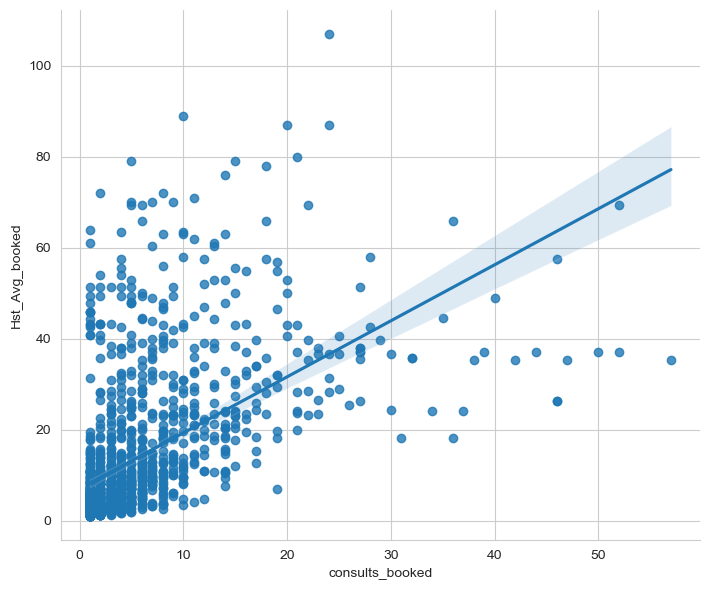

In [275]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set style of plots
sns.set_style("whitegrid")

# Create scatterplot with regression line
sns.lmplot(x="consults_booked", y="Hst_Avg_booked", data=df4, height=6, aspect=1.2)

# Set labels
plt.xlabel("consults_booked")
plt.ylabel("Hst_Avg_booked")

# Show plot
plt.show()

In [277]:
# Underfilling
df_min_weeks_out[(df_min_weeks_out['apt_week'] > current_date) & (df_min_weeks_out['booked_variation'] < .5) & (df_min_weeks_out['FIS_Status'] != 'Open')]

,center,FIS_Status,apt_week,weeks_out,consults_booked,total_booked,Hst_Avg_booked,booked_variation,inventory,inventory_fill
43,Atlanta,Medium,2023-04-17,3,1,2,9.3,0.215054,54,0.037037
80,Atlanta Decatur,Medium,2023-05-01,5,1,4,12.6,0.317460,70,0.057143
109,Birmingham,Medium,2023-04-17,4,2,24,49.5,0.484848,42,0.571429
188,Charlotte,Closed,2023-05-08,6,4,4,18.2,0.219780,56,0.071429
195,Chicago,Medium,2023-04-17,3,3,4,19.5,0.205128,32,0.125000
243,Cincinnati,Medium,2023-04-17,3,4,11,22.3,0.493274,36,0.305556
407,Detroit Southfield,Closed,2023-05-08,6,1,1,4.0,0.250000,56,0.017857
437,Fresno,Medium,2023-05-01,5,1,1,5.0,0.200000,87,0.011494
457,Greenville,Medium,2023-05-08,6,1,1,2.2,0.454545,56,0.017857
541,Indianapolis,Medium,2023-05-01,5,2,5,12.0,0.416667,66,0.075758


In [279]:
# Overfilling
df_min_weeks_out[(df_min_weeks_out['apt_week'] > current_date) & (df_min_weeks_out['booked_variation'] > 1.5)].sort_values(['inventory_fill'], ascending= False)

,center,FIS_Status,apt_week,weeks_out,consults_booked,total_booked,Hst_Avg_booked,booked_variation,inventory,inventory_fill
539,Indianapolis,Medium,2023-04-24,4,9,43,23.2,1.853448,68,0.632353
894,New York Long Island City,Medium,2023-04-24,4,5,26,14.5,1.793103,65,0.400000
667,Louisville,Closed,2023-04-24,5,14,15,7.7,1.948052,48,0.312500
1100,Providence,Open,2023-04-24,5,5,9,5.0,1.800000,36,0.250000
1068,Pittsburgh,Open,2023-04-24,4,3,16,8.8,1.818182,66,0.242424
951,Oklahoma City,Medium,2023-04-24,4,4,10,6.0,1.666667,56,0.178571
227,Chicago Schaumburg,Open,2023-04-24,5,4,6,3.3,1.818182,52,0.115385
506,Houston,Open,2023-04-24,4,3,10,5.7,1.754386,91,0.109890
610,Los Angeles Orange County,Open,2023-04-24,5,7,7,4.0,1.750000,76,0.092105
